In [280]:
import atd2022
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import my_mod as util
import importlib
importlib.reload(util)

<module 'my_mod' from '/Users/griffinheyrich/git atd2022/LISP-ATD-2022/my_mod.py'>

In [3]:
print("12")

12


In [4]:
pd.options.display.max_columns = None

# 1-dim CNN experiment on 20-dim time series vector

# Data Import/Preprocessing

In [5]:
data = atd2022.io.read_csv()

In [6]:
test_region=data["AA"]

In [7]:
len(test_region)

215

In [8]:
test_region.tail(6)

Event,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20
2018-01-01/2018-01-07,7,5,26,22,5,0,0,1,1,0,3,1,0,0,0,0,1,0,0,0
2018-01-08/2018-01-14,13,9,20,85,4,2,0,2,8,0,0,0,0,0,0,1,8,0,0,0
2018-01-15/2018-01-21,14,5,8,10,1,0,0,1,0,1,0,1,0,0,0,0,3,0,2,0
2018-01-22/2018-01-28,5,2,0,23,3,2,5,1,0,0,2,0,0,0,0,3,4,0,4,0
2018-01-29/2018-02-04,3,2,7,37,6,10,4,7,0,1,1,1,0,0,0,0,0,0,0,0
2018-02-05/2018-02-11,7,6,7,49,6,0,1,2,2,2,6,0,1,0,0,0,2,0,4,0


In [9]:
test=util.getMultiDXY(test_region, n_lags=2)

In [10]:
test

(array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 2.,  0.,  0., ...,  0.,  0.,  0.]],
 
        [[ 2.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  1.,  3., ...,  0.,  1.,  0.]],
 
        [[ 0.,  1.,  3., ...,  0.,  1.,  0.],
         [ 0.,  1.,  0., ...,  0.,  0.,  0.]],
 
        ...,
 
        [[13.,  9., 20., ...,  0.,  0.,  0.],
         [14.,  5.,  8., ...,  0.,  2.,  0.]],
 
        [[14.,  5.,  8., ...,  0.,  2.,  0.],
         [ 5.,  2.,  0., ...,  0.,  4.,  0.]],
 
        [[ 5.,  2.,  0., ...,  0.,  4.,  0.],
         [ 3.,  2.,  7., ...,  0.,  0.,  0.]]]),
 array([[ 0.,  1.,  3., ...,  0.,  1.,  0.],
        [ 0.,  1.,  0., ...,  0.,  0.,  0.],
        [ 6.,  1., 59., ...,  0.,  0.,  0.],
        ...,
        [ 5.,  2.,  0., ...,  0.,  4.,  0.],
        [ 3.,  2.,  7., ...,  0.,  0.,  0.],
        [ 7.,  6.,  7., ...,  0.,  4.,  0.]]))

In [17]:
x,y = util.getMultiDXY(test_region, n_lags=2)

In [18]:
x

array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 2.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 2.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  1.,  3., ...,  0.,  1.,  0.]],

       [[ 0.,  1.,  3., ...,  0.,  1.,  0.],
        [ 0.,  1.,  0., ...,  0.,  0.,  0.]],

       ...,

       [[13.,  9., 20., ...,  0.,  0.,  0.],
        [14.,  5.,  8., ...,  0.,  2.,  0.]],

       [[14.,  5.,  8., ...,  0.,  2.,  0.],
        [ 5.,  2.,  0., ...,  0.,  4.,  0.]],

       [[ 5.,  2.,  0., ...,  0.,  4.,  0.],
        [ 3.,  2.,  7., ...,  0.,  0.,  0.]]])

In [19]:
y

array([[ 0.,  1.,  3., ...,  0.,  1.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 6.,  1., 59., ...,  0.,  0.,  0.],
       ...,
       [ 5.,  2.,  0., ...,  0.,  4.,  0.],
       [ 3.,  2.,  7., ...,  0.,  0.,  0.],
       [ 7.,  6.,  7., ...,  0.,  4.,  0.]])

In [20]:
y.shape

(213, 20)

In [22]:
x.shape

(213, 2, 20)

In [23]:
# (#of samples, timesteps, #features(i.e. number of parallel time series))

In [24]:
n_features = 20
x_train=x.reshape((x.shape[0], x.shape[1], n_features))

In [25]:
x_train.shape

(213, 2, 20)

In [26]:
y_train=y

# CNN Model Building

In [27]:
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader
import gc
device=torch.device("cpu")

In [28]:
class CNN_ForecastNet(nn.Module):
    def __init__(self):
        super(CNN_ForecastNet,self).__init__()
        self.conv1d = nn.Conv1d(2,128,kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(128,64)
        self.fc2 = nn.Linear(64,1)
        
    def forward(self,x):
        x = self.conv1d(x)
        x = self.relu(x)
        #print(x.shape)
        x = x.view(-1,128)
        #print(x.shape)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

In [29]:
model = CNN_ForecastNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()

In [30]:
class myDataset(Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        
        return item,label

In [59]:
train = myDataset(x_train,y_train)
train_loader = torch.utils.data.DataLoader(train,batch_size=1,shuffle=False)

In [60]:
train_losses = []
valid_losses = []
def Train():
    
    running_loss = .0
    
    model.train()
    
    for idx, (inputs,labels) in enumerate(train_loader):
        inputs=inputs.to(torch.float32)
        labels=labels.to(torch.float32)
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad(set_to_none = True)
        preds = model(inputs.float())
        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.detach().numpy())
    
    print(f'train_loss {train_loss}')

def Valid():
    running_loss = .0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            loss = criterion(preds,labels)
            running_loss += loss
            
        valid_loss = running_loss/len(valid_loader)
        valid_losses.append(valid_loss.detach().numpy())
        print(f'valid_loss {valid_loss}')

In [61]:
epochs = 20
for epoch in range(epochs):
    print('epochs {}/{}'.format(epoch+1,epochs))
    Train()
    #Valid()
    gc.collect()

epochs 1/20
train_loss 84.16117095947266
epochs 2/20
train_loss 84.15989685058594
epochs 3/20
train_loss 84.15828704833984
epochs 4/20
train_loss 84.15709686279297
epochs 5/20
train_loss 84.15557098388672
epochs 6/20
train_loss 84.15420532226562
epochs 7/20
train_loss 84.15274047851562
epochs 8/20
train_loss 84.15138244628906
epochs 9/20
train_loss 84.15001678466797
epochs 10/20
train_loss 84.14848327636719
epochs 11/20
train_loss 84.14716339111328
epochs 12/20
train_loss 84.14579772949219
epochs 13/20
train_loss 84.14424133300781
epochs 14/20
train_loss 84.14291381835938
epochs 15/20
train_loss 84.14151763916016
epochs 16/20
train_loss 84.1400375366211
epochs 17/20
train_loss 84.13875579833984
epochs 18/20
train_loss 84.13734436035156
epochs 19/20
train_loss 84.13581085205078
epochs 20/20
train_loss 84.13443756103516


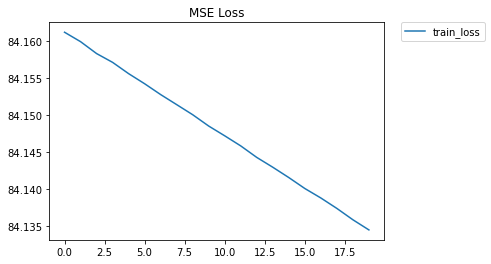

In [62]:
import matplotlib.pyplot as plt
plt.plot(train_losses,label='train_loss')
#plt.plot(valid_losses,label='valid_loss')
plt.title('MSE Loss')
#plt.ylim(0, 100)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# Testing Set Preparation/Model testing

In [215]:
tmp_stack = np.zeros(shape=(20))

In [274]:
last2 = test_region.tail(2)

In [275]:
last2=last2.to_numpy()

In [278]:
last2[0]

array([ 3,  2,  7, 37,  6, 10,  4,  7,  0,  1,  1,  1,  0,  0,  0,  0,  0,
        0,  0,  0])

In [279]:
test=last2[-2:].reshape(1,last2.shape[0], last2.shape[1])

In [262]:
test

array([[[ 3,  2,  7, 37,  6, 10,  4,  7,  0,  1,  1,  1,  0,  0,  0,  0,
          0,  0,  0,  0],
        [ 7,  6,  7, 49,  6,  0,  1,  2,  2,  2,  6,  0,  1,  0,  0,  0,
          2,  0,  4,  0]]])

In [245]:
last2.reshape(1,last2.shape[0], last2.shape[1])

array([[[ 3,  2,  7, 37,  6, 10,  4,  7,  0,  1,  1,  1,  0,  0,  0,  0,
          0,  0,  0,  0],
        [ 7,  6,  7, 49,  6,  0,  1,  2,  2,  2,  6,  0,  1,  0,  0,  0,
          2,  0,  4,  0]]])

In [217]:
tmp_stack

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [218]:
tmp_stack = np.vstack((tmp_stack, last2.to_numpy()[0]))

In [219]:
tmp_stack

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 3.,  2.,  7., 37.,  6., 10.,  4.,  7.,  0.,  1.,  1.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [186]:
x_test, y_test=util.get_testXY(test_region, 2, 2)

In [166]:
x_test.shape

(4, 2, 20)

In [241]:
x_test

array([[[14.,  5.,  8., 10.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,
          0.,  0.,  0.,  0.,  3.,  0.,  2.,  0.],
        [ 5.,  2.,  0., 23.,  3.,  2.,  5.,  1.,  0.,  0.,  2.,  0.,
          0.,  0.,  0.,  3.,  4.,  0.,  4.,  0.]],

       [[ 5.,  2.,  0., 23.,  3.,  2.,  5.,  1.,  0.,  0.,  2.,  0.,
          0.,  0.,  0.,  3.,  4.,  0.,  4.,  0.],
        [ 3.,  2.,  7., 37.,  6., 10.,  4.,  7.,  0.,  1.,  1.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]])

In [138]:
predictions = util.pred_next_n(x_test, model, 4)

In [139]:
len(predictions)

4

In [150]:
util.metrics_mse(predictions, y_test)

15.228501195216642
27.255348047347354
82.84249005730368
127.15255894301659


In [269]:
test=test_region.tail(2)

In [270]:
test

Event,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20
2018-01-29/2018-02-04,3,2,7,37,6,10,4,7,0,1,1,1,0,0,0,0,0,0,0,0
2018-02-05/2018-02-11,7,6,7,49,6,0,1,2,2,2,6,0,1,0,0,0,2,0,4,0


In [281]:
pred = util.prod_pred_next_n(test, model)

1
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/griffinheyrich/opt/anaconda3/envs/atd2022/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/b6/b7gcphkx3b3b2vwy13kj5dmw0000gn/T/com.apple.messages/ipykernel_9090/3471555672.py", line 1, in <cell line: 1>
    pred = util.prod_pred_next_n(test, model)
  File "/Users/griffinheyrich/git atd2022/LISP-ATD-2022/my_mod.py", line 110, in prod_pred_next_n
    tmp_stack = np.vstack((tmp_stack, last_n_rows.to_numpy()[0]))
AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/griffinheyrich/opt/anaconda3/envs/atd2022/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 1993, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/Users/griffinheyrich/opt/anaconda3/envs/atd20